## Variational Autoencoder for face reconstruction and generation

In [1]:
import os
import numpy as np
from PIL import Image
import constants as const
import utils.utils as utils
from matplotlib import pyplot as plt
from variational_autoencoder import VariationalAutoencoder

%matplotlib inline


/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Data, constants, and functions for use throughout this notebook:

PROJECT_NAME = 'celebA'
DEFAULT_MODEL_NAME = PROJECT_NAME + '_model'

IMAGE_NUM = 151
NUM_SUBPLOTS = 11

def get_feature_direction(VAE, feature_images_dict, feature, num_images):
    
#   Get the vector in the latent space that points in the direction of a particular feature.
    
    assert feature in feature_images_dict
    
    with_feature_index_list = feature_images_dict[feature]
    wout_feature_index_list = [i for i in range(num_images) if i not in feature_images_dict[feature]]
    
    cutoff = min(1000, len(with_feature_index_list), len(wout_feature_index_list))
    
    with_feature = np.mean(VAE.encode(IMAGE_ARRAY[with_feature_index_list[:cutoff]])[0], axis = 0)
    wout_feature = np.mean(VAE.encode(IMAGE_ARRAY[wout_feature_index_list[:cutoff]])[0], axis = 0)
    
    return with_feature - wout_feature


In [3]:
# More data and constants for use throughout this notebook.

# This cell will pickle and save a large numpy array with NUM_IMAGES x 64 x 64 x 3 images,
# with each image containing the cropped face. The final file could be over 1GB.
# File structure must be as follows in order for this cell to run:
#     root
#       |--variational_autoencoder.py
#       |--constants.py
#       |utils
#       |   |--utils.py
#       |
#       |--celebA
#           |--data
#               |--list_attr_celeba.txt (can be found at "http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html")
#               |--img_align_celeba (can be found at "http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html")
#                         |--000001.jpg (image 1 of a face)
#                         |--000002.jpg (image 2 of a face)
#                         |--000003.jpg (image 3 of a face)
#                         |--etc.
# You might also need to change the value of 'PATH_FACEDATA' in 'constants.py' to match your installation of OpenCV.

NUM_IMAGES = 15000

IMAGES_NAME = 'img_align_celeba' # Directory containing all face images to be processed ('.jpg' only).
ATTRIB_NAME = 'list_attr_celeba.txt' # File containing face attribute annotations.
PICKLE_NAME = PROJECT_NAME + '_' + str(NUM_IMAGES) # Name of the pickled file with images of the cropped faces.
DETAIL_NAME = PICKLE_NAME + '_details' # Name of the pickled file with a dictionary of face attribute annotations.

# Pickle and save a numpy array with NUM_IMAGES x 64 x 64 x 3 images, each image containing the cropped face.
# The final file could be over 1GB:
utils.get_cropped_faces(PROJECT_NAME, IMAGES_NAME, PICKLE_NAME, ATTRIB_NAME, NUM_IMAGES)

# # For perceptual loss (not used in this notebook, this can be commented out...
# # ('vgg16_weights.npz' can be found at "https://www.cs.toronto.edu/~frossard/post/vgg16/"
# # and should be placed in /celebA/data):
# WEIGHTS_PATH = os.path.join(const.PATH_ROOT, PROJECT_NAME, const.DIR_DATA, 'vgg16_weights.npz')
# WEIGHTS_DICT = np.load(WEIGHTS_PATH)

# celebA image data, shaped to NUM_IMAGES x 64 x 64 x 3 images (altogether a 4-tensor) with values from 0 to 255. 
IMAGE_ARRAY, FEATURES_IMAGES_DICT = utils.load_data(PROJECT_NAME, PICKLE_NAME)
print('Input data shape:', IMAGE_ARRAY.shape)
    
INPUT_X = IMAGE_ARRAY.shape[1] # x dimension of input images,
INPUT_Y = IMAGE_ARRAY.shape[2] # y dimension of input images,
INPUT_Z = IMAGE_ARRAY.shape[3] # z dimension (three, images are RGB).

INPUTS_SHAPE_LIST = [INPUT_X, INPUT_Y, INPUT_Z]


Input data shape: (15000, 64, 64, 3)


##  Tensorboard graph for an autoencoder with convolution layers

In [4]:
# Check out the computational graph with tensorboard:

encoder_list = [{'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [256], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [100]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [4 * 4 * 256], 'activation': 'relu'},
                {'layer_type': 'reshape', 'output_shape': [4, 4, 256]},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [3],   'pool_shape': [2, 2], 'activation': 'sigmoid'}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'loss_type': 'pixel',
                      'is_variational': True,
                      'encoder_loss_weight': 1.0,
                      'decoder_loss_weight': 1.0,
                      'learning_rate': 0.001}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    VAE.show_graph()
    

In [5]:
# Get the layer shapes for a newly created model:

encoder_list = [{'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [256], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'reshape'},
                {'layer_type': 'full_cn', 'output_shape': [100]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [4 * 4 * 256], 'activation': 'relu'},
                {'layer_type': 'reshape', 'output_shape': [4, 4, 256]},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [3],   'pool_shape': [2, 2], 'activation': 'sigmoid'}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'loss_type': 'pixel',
                      'is_variational': True,
                      'encoder_loss_weight': 1.0,
                      'decoder_loss_weight': 1.0,
                      'learning_rate': 0.001}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    print('Inputs shape:\n', VAE.inputs_shape, '\n')

    print('Encoder shape list:')
    for item in VAE.encoder_shape_list:
        print(item)
    print('\n')
    
    print('Latent shape:\n', VAE.latent_shape, '\n')
    
    print('Decoder shape list:')
    for item in VAE.decoder_shape_list:
        print(item)
    print('\n')
    
    print('Output shape:\n', VAE.output_shape, '\n')
    
    print('Altogether, the layer shape list for the entire variational autoencoder:')
    for item in VAE.layer_shape_list:
        print(item)
    

Inputs shape:
 [64 64  3] 

Encoder shape list:
[64 64  3]
[32 32 32]
[16 16 64]
[  8   8 128]
[  4   4 256]
[4096]
[100]


Latent shape:
 [100] 

Decoder shape list:
[100]
[4096]
[  4   4 256]
[  8   8 128]
[16 16 64]
[32 32 32]
[64 64  3]


Output shape:
 [64 64  3] 

Altogether, the layer shape list for the entire variational autoencoder:
[64 64  3]
[32 32 32]
[16 16 64]
[  8   8 128]
[  4   4 256]
[4096]
[100]
[4096]
[  4   4 256]
[  8   8 128]
[16 16 64]
[32 32 32]
[64 64  3]


## Two-dimensional variational autoencoder with convolution layers

Train a variational autoencoder with
    1. encoder = four convolution layers followed by one fully connected layer.
    2. decoder = one fully connected layer followed by four deconvolution layers.
    3. latent space dimension = 100
    

In [6]:
# Train a new convolutional model:

encoder_list = [{'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'convolu', 'kernel_shape': [4, 4], 'output_chann': [256], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'reshape', 'output_shape': [4 * 4 * 256]},
                {'layer_type': 'full_cn', 'output_shape': [100]}]

decoder_list = [{'layer_type': 'full_cn', 'output_shape': [4 * 4 * 256], 'activation': 'relu'},
                {'layer_type': 'reshape', 'output_shape': [4, 4, 256]},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [128], 'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [64],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [32],  'pool_shape': [2, 2], 'activation': 'relu'},
                {'layer_type': 'deconvo', 'kernel_shape': [4, 4], 'output_chann': [3],   'pool_shape': [2, 2], 'activation': 'sigmoid'}]

model_details_dict = {'encoder_list': encoder_list,
                      'decoder_list': decoder_list,
                      'inputs_shape_list': INPUTS_SHAPE_LIST,
                      'project_name': PROJECT_NAME,
                      'model_name': DEFAULT_MODEL_NAME,
                      'loss_type': 'pixel',
                      'is_variational': True,
                      'encoder_loss_weight': 1.0,
                      'decoder_loss_weight': 1.0,
                      'learning_rate': 0.001}

with VariationalAutoencoder(model_details_dict) as VAE:

    model_name_1 = VAE.model_name
    
    VAE.train_model(IMAGE_ARRAY, batch_size = 40, num_training_epochs = 30, display_step = 5)




Epoch 5 of 30 completed. Total time elapsed so far: 1983.641
------------------------------------------------------------
Loss over all input data: 6629.904
Time to train last epoch: 404.407


Epoch 10 of 30 completed. Total time elapsed so far: 4001.112
-------------------------------------------------------------
Loss over all input data: 6578.783
Time to train last epoch: 414.06


Epoch 15 of 30 completed. Total time elapsed so far: 12371.514
--------------------------------------------------------------
Loss over all input data: 6553.444
Time to train last epoch: 394.493


Epoch 20 of 30 completed. Total time elapsed so far: 23308.456
--------------------------------------------------------------
Loss over all input data: 6541.116
Time to train last epoch: 407.294


Epoch 25 of 30 completed. Total time elapsed so far: 25354.578
--------------------------------------------------------------
Loss over all input data: 6531.846
Time to train last epoch: 412.768


Epoch 30 of 30 compl

## Face reconstruction

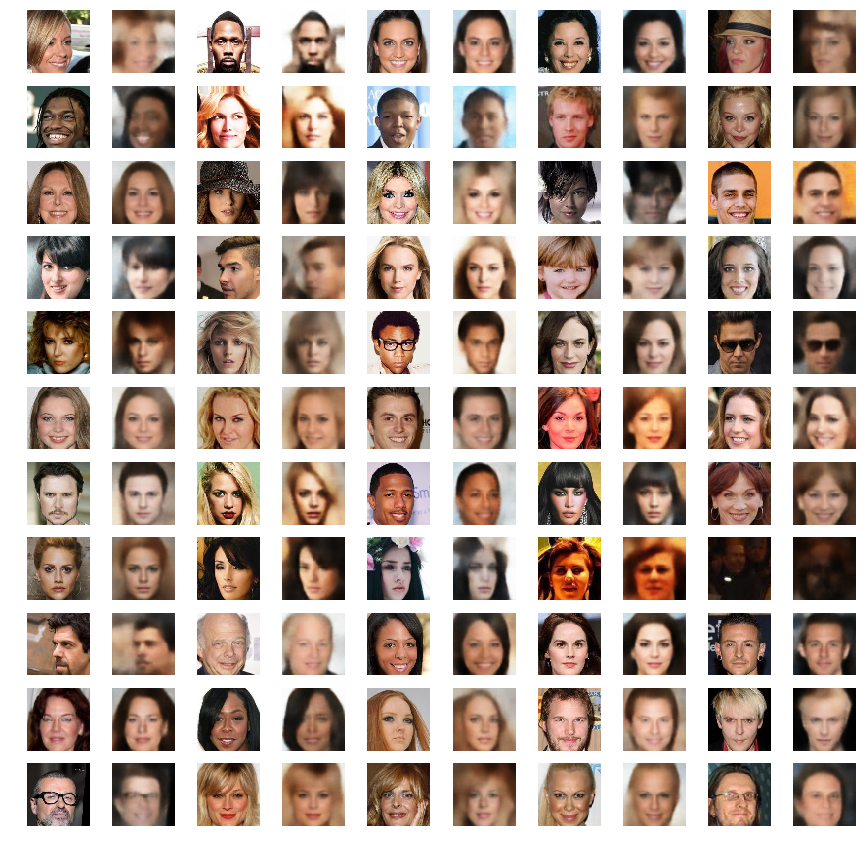

In [7]:
# Use the trained model to reconstruct the first several faces in our training dataset:

model_details_dict = {'project_name': PROJECT_NAME,
                      'model_name': model_name_1}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    num_rows = NUM_SUBPLOTS
    num_cols = int(NUM_SUBPLOTS / 2)
    
    plt.subplots(num_rows, 2 * num_cols, figsize = (15, 15))
    
    for i in range(num_rows):
        for j in range(num_cols):

#           Use the variational autoencoder to reconstruct the input image:
            input_image = IMAGE_ARRAY[num_cols * i + j: num_cols * i + j + 1] # Original.
            faked_image = VAE.reform(input_image)                             # Fake.

            for k, image in enumerate([input_image, faked_image]):

                plt.subplot(num_rows, 2 * num_cols, 2 * i * num_cols + 2 * j + k + 1)
                plt.imshow(image[0])
                plt.axis('off')
        
    plt.show()
    

## Face generation

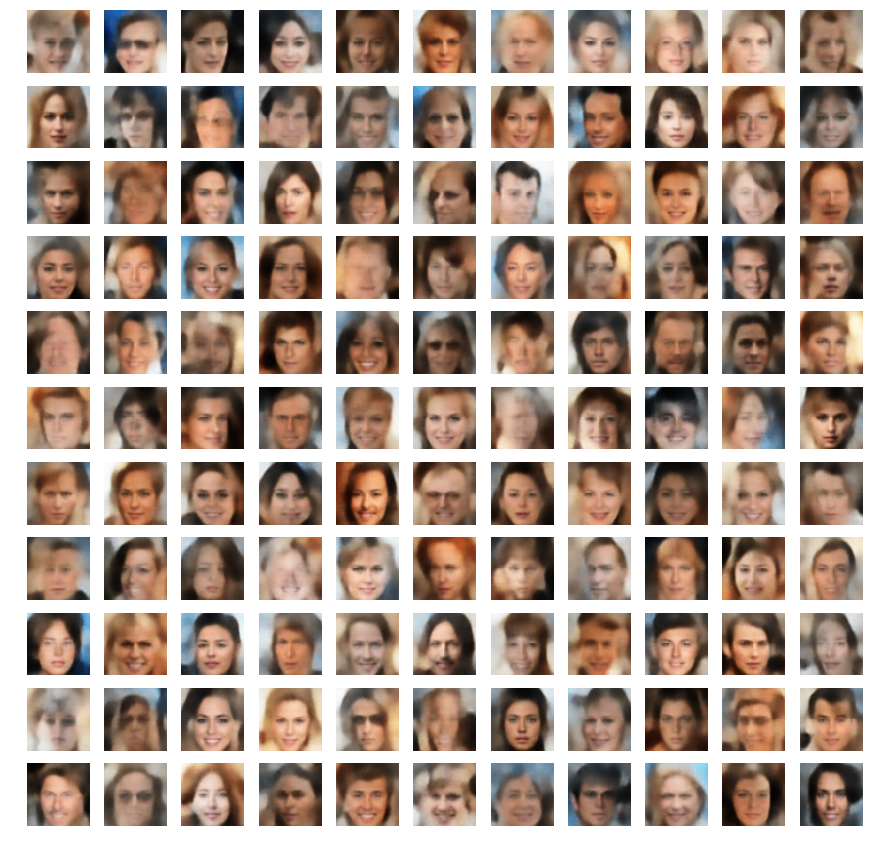

In [6]:
# Use the trained model to generate fake images of faces:

model_details_dict = {'project_name': PROJECT_NAME,
                      'model_name': model_name_1}

with VariationalAutoencoder(model_details_dict) as VAE:
    
    num_rows = NUM_SUBPLOTS
    num_cols = NUM_SUBPLOTS
    
    plt.subplots(num_rows, num_cols, figsize = (15, 15))
    
    for i in range(num_rows):
        for j in range(num_cols):

#           Use the variational autoencoder to generate fake images with random seeds:
            faked_image = VAE.decode()

            plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
            plt.imshow(faked_image[0])
            plt.axis('off')
            
    plt.show()


## Face interpolation

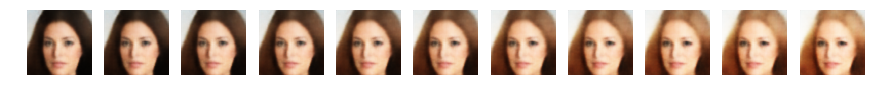

In [7]:
# Gradually convert hair color from brown or black to blond:

feature = 'Blond_Hair'
model_details_dict = {'project_name': PROJECT_NAME,
                      'model_name': model_name_1}

assert feature in FEATURES_IMAGES_DICT
assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature]

with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Encode the original face:
    wout_feature_sample = VAE.encode(IMAGE_ARRAY[IMAGE_NUM: IMAGE_NUM + 1])[0]
    
#   Get the vector that points in the direction of 'feature':
    feature_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature, len(IMAGE_ARRAY))
    
    plt.subplots(1, NUM_SUBPLOTS, figsize = (15, 15))
    
    for i in range(NUM_SUBPLOTS):
        
#       Add increasing multiplies of 'feature_delta' to superimpose 'feature' onto the original image:
        with_feature_sample = wout_feature_sample + feature_delta * (3 * i / (NUM_SUBPLOTS - 1))

        plt.subplot(1, NUM_SUBPLOTS, i + 1)
        plt.imshow(VAE.decode(with_feature_sample)[0])
        plt.axis('off')
        
    plt.show()


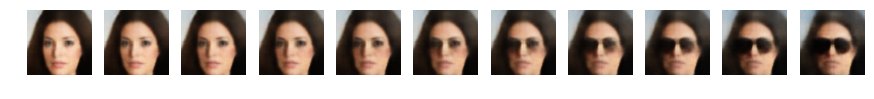

In [8]:
# Gradually add sunglasses to a face without them:

feature = 'Eyeglasses'
model_details_dict = {'project_name': PROJECT_NAME,
                      'model_name': model_name_1}

assert feature in FEATURES_IMAGES_DICT
assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature]

with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Encode the original face:
    wout_feature_sample = VAE.encode(IMAGE_ARRAY[IMAGE_NUM: IMAGE_NUM + 1])[0]
    
#   Get the vector that points in the direction of 'feature':
    feature_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature, len(IMAGE_ARRAY))
    
    plt.subplots(1, NUM_SUBPLOTS, figsize = (15, 15))
    
    for i in range(NUM_SUBPLOTS):
        
#       Add increasing multiplies of 'feature_delta' to superimpose 'feature' onto the original image:
        with_feature_sample = wout_feature_sample + feature_delta * (4 * i / (NUM_SUBPLOTS - 1))

        plt.subplot(1, NUM_SUBPLOTS, i + 1)
        plt.imshow(VAE.decode(with_feature_sample)[0])
        plt.axis('off')
        
    plt.show()

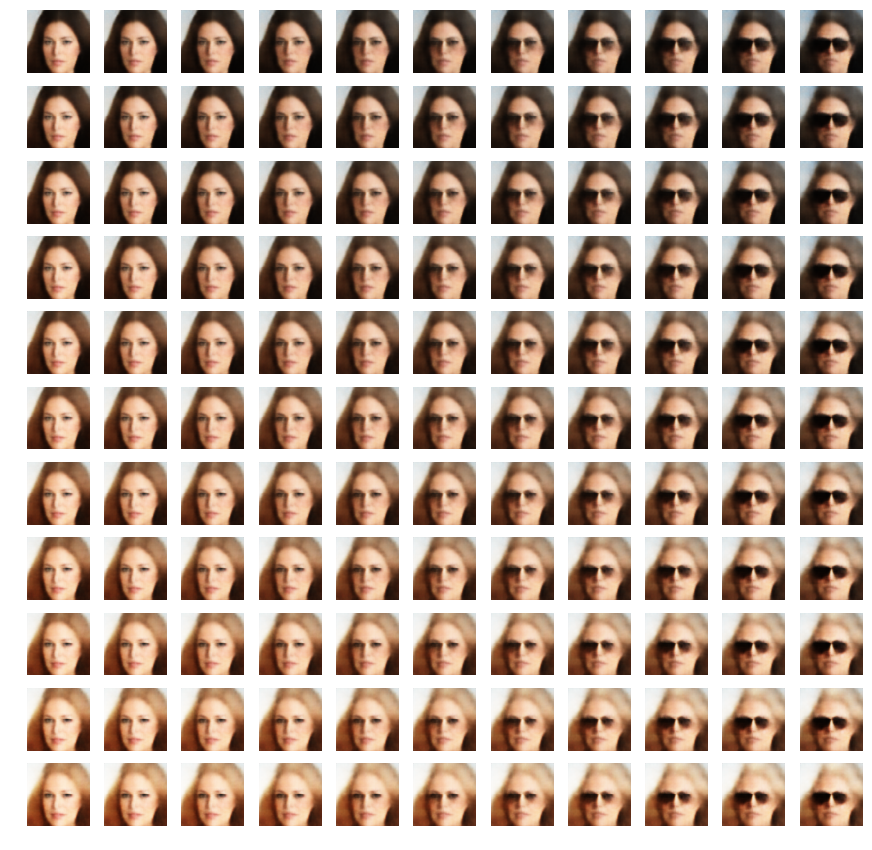

In [9]:
# Gradually add suglasses to a face without them and change hair color to blond:

feature_1 = 'Blond_Hair'
feature_2 = 'Eyeglasses'
model_details_dict = {'project_name': PROJECT_NAME,
                      'model_name': model_name_1}

assert feature_1 in FEATURES_IMAGES_DICT
assert feature_2 in FEATURES_IMAGES_DICT

assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature_1]
assert IMAGE_NUM not in FEATURES_IMAGES_DICT[feature_2]

with VariationalAutoencoder(model_details_dict) as VAE:
    
#   Encode the original face:
    wout_feature_sample = VAE.encode(IMAGE_ARRAY[IMAGE_NUM: IMAGE_NUM + 1])[0]
    
#   Get the vectors that points in the direction of 'feature_1' and 'feature_2' respectively:
    feature_1_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature_1, len(IMAGE_ARRAY))
    feature_2_delta = get_feature_direction(VAE, FEATURES_IMAGES_DICT, feature_2, len(IMAGE_ARRAY))
    
    plt.subplots(NUM_SUBPLOTS, NUM_SUBPLOTS, figsize = (15, 15))
    
    for i in range(NUM_SUBPLOTS):
        for j in range(NUM_SUBPLOTS):

#           Add increasing multiplies of 'feature_delta_1' and 'feature_delta_2' to superimpose 
#          'feature_1' and 'feature_2' onto the original image:
            with_feature_sample = wout_feature_sample + feature_1_delta * (3 * i / (NUM_SUBPLOTS - 1)) \
                                + feature_2_delta * (4 * j / (NUM_SUBPLOTS - 1))

            plt.subplot(NUM_SUBPLOTS, NUM_SUBPLOTS, NUM_SUBPLOTS * i + j + 1)
            plt.imshow(VAE.decode(with_feature_sample)[0])
            plt.axis('off')
            
    plt.show()
